### Correlation Analysis Between Prices and StockTwits Sentiment

The following code prepares stock price data for analysis. It loads the stock price data, adds lagged features to it, and aggregates it to weekly frequency, selecting the last observation of each week. 

In [38]:

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../..")
from utils.StockPricesProcess import load_prices_df, add_lags

# defining the path to the stock prices data and the date range
df_path = "../../data/stock_prices/yfinance/AAPL_prices_2019-01-01_2020-01-01.csv"
start_date_string = "2019-01-01"
end_date_string = "2020-01-01"

# Load stock prices and add lags using functions from StockPricesProcess.py
stock_data = load_prices_df(path=df_path, start_date_string=start_date_string, end_date_string=end_date_string)
stock_data = add_lags(stock_data=stock_data.copy(), numLags=3)
stock_data["Date"] = stock_data.index

weekly_prices = stock_data.resample("W-Fri", on="Date").last()
print(weekly_prices.shape)
weekly_prices.head()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(53, 8)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\omare\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\omare\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\omare\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Open,High,Low,Close,Volume,Close_Lag1,Close_Lag2,Close_Lag3
Date,,,,,,,,
2019-01-04 00:00:00+00:00,34.636170,35.599552,34.461229,35.530052,234428400,34.075401,37.845039,37.845039
2019-01-11 00:00:00+00:00,36.637221,36.833730,36.308902,36.495827,108092800,36.857697,36.740273,36.126770
2019-01-18 00:00:00+00:00,37.744387,37.835454,37.380122,37.581429,135004000,37.351372,37.130898,36.682758
2019-01-25 00:00:00+00:00,37.260307,37.895374,36.982319,37.806702,134142000,36.594078,36.886452,36.737877
2019-02-01 00:00:00+00:00,40.011451,40.495535,39.764611,39.906006,130672400,39.886833,39.601646,37.068588


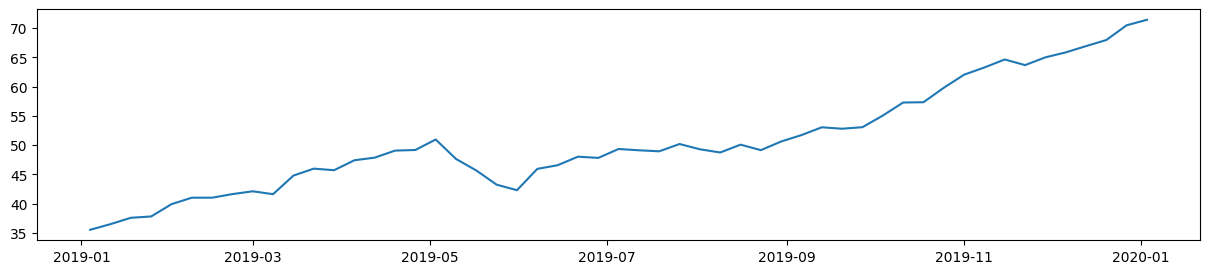

In [39]:
plt.figure(figsize=(15, 3))
plt.plot(weekly_prices.index, weekly_prices['Close'],)

This code snippet reads a CSV file containing stock-related messages from StockTwits for the AAPL stock. It converts the 'datetime' column to datetime objects with UTC timezone. Then, it filters the data to include only messages within the specified date range.


In [40]:
import pandas as pd  # Importing pandas library for data manipulation

# Reading stocktwits data from CSV file into a DataFrame
stock_twits = pd.read_csv("../../data/stocktwits/stocktwits_AAPL.csv")

# Converting the 'datetime' column to datetime objects and assigning to 'Date' column
stock_twits["Date"] = pd.to_datetime(stock_twits["datetime"], utc=True)

# Converting start_date_string and end_date_string to datetime objects with UTC timezone
start_date = pd.to_datetime(start_date_string, utc=True)
end_date = pd.to_datetime(end_date_string, utc=True)

# Filtering stock_twits DataFrame to include only rows within the specified date range
stock_twits = stock_twits.loc[(stock_twits["Date"] >= start_date) & (stock_twits["Date"] <= end_date)]

# Printing the minimum and maximum dates in the filtered stock_twits DataFrame
print("Minimum Date:", stock_twits["Date"].min())
print("Maximum Date:", stock_twits["Date"].max())

# Printing the shape (number of rows and columns) of the filtered stock_twits DataFrame
stock_twits.shape


Minimum Date: 2019-01-01 00:08:25+00:00
Maximum Date: 2019-12-31 23:57:46+00:00


(184583, 6)

preprocesse the text messages from StockTwits data by applying the function preprocess_text() imported from the SentimentAnalysis.py module.


In [41]:
import sys
sys.path.append('../..')
from utils.SentimentAnalysis import preprocess_text

stock_twits["processed_message"] = stock_twits["message"].apply(preprocess_text)



Calculate sentiment scores for the processed messages using the function called get_vader_sentiment_score imported from the SentimentAnalysis.py module.


In [42]:
from utils.SentimentAnalysis import get_vader_sentiment_score

stock_twits["sentiment_score"] = stock_twits["processed_message"].apply(get_vader_sentiment_score)

In [43]:
tweets_aggregated_score = stock_twits.groupby("Date")["sentiment_score"].mean().reset_index()

In [44]:
tweets_aggregated_score.head()

,Date,sentiment_score
0,2019-01-01 00:08:25+00:00,0.4019
1,2019-01-01 00:14:16+00:00,-0.3818
2,2019-01-01 00:14:17+00:00,0.0000
3,2019-01-01 00:19:15+00:00,-0.7096
4,2019-01-01 00:20:30+00:00,0.0000


In [45]:
tweets_aggregated_score.set_index("Date", inplace=True)

In [46]:
# tweets_aggregated_score.set_index(pd.to_datetime(tweets_aggregated_score.index), inplace=True)
weekly_sentiment_scores = tweets_aggregated_score.resample('W-Fri').mean()
# weekly_sentiment_scores.reset_index(inplace=True)
weekly_sentiment_scores.head()


,sentiment_score
Date,
2019-01-04 00:00:00+00:00,0.028546
2019-01-11 00:00:00+00:00,0.053635
2019-01-18 00:00:00+00:00,0.059731
2019-01-25 00:00:00+00:00,0.059139
2019-02-01 00:00:00+00:00,0.074093


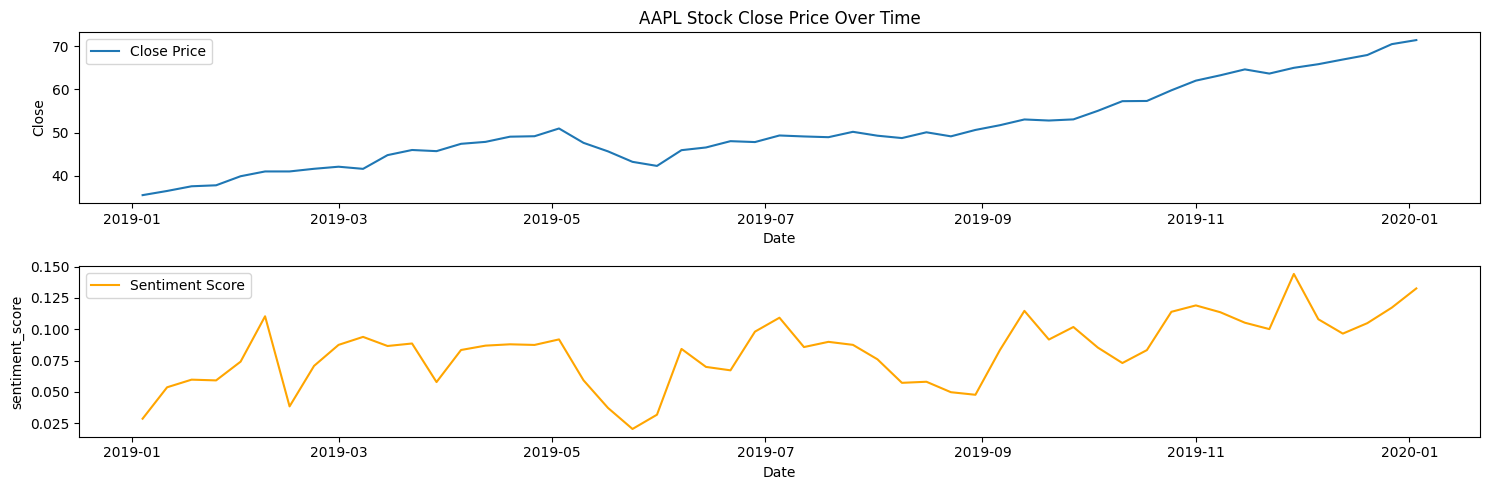

In [47]:
import seaborn as sns

plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
sns.lineplot(x=weekly_prices.index, y=weekly_prices["Close"], label="Close Price")
plt.title("AAPL Stock Close Price Over Time")
plt.subplot(2, 1, 2)
sns.lineplot(x=weekly_sentiment_scores.index, y=weekly_sentiment_scores["sentiment_score"], label="Sentiment Score", color="orange")
plt.tight_layout()
plt.show()

In [48]:
close_prices = weekly_prices["Close"]
sentiment_scores = weekly_sentiment_scores["sentiment_score"]

close_prices.index = pd.to_datetime(close_prices.index).tz_localize(None) 
sentiment_scores.index = pd.to_datetime(sentiment_scores.index).tz_localize(None)  

data = pd.DataFrame({'Close Price': close_prices, 'Sentiment Score': sentiment_scores})

correlation_matrix = data.corr()

print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                 Close Price  Sentiment Score
Close Price         1.000000         0.686181
Sentiment Score     0.686181         1.000000


In [49]:
weekly_prices.head()
weekly_sentiment_scores.index = weekly_sentiment_scores.index.tz_localize(None)


This code snippet computes Pearson correlation coefficient, the standard error, and the p-value. between sentiment scores with various time lags and stock closing prices.

In [53]:
from scipy.stats import pearsonr, t
import numpy as np

time_lags = [-9, -7, -5, -3, -1, 0, 1, 3, 5, 7, 9]

# Lists to store results
coefficients = []
standard_errors = []
p_values = []
t_scores = []

for lag in time_lags:
    lag_column_name = f'Sentiment_Lag_{lag}'
    weekly_sentiment_scores[lag_column_name] = weekly_sentiment_scores['sentiment_score'].shift(lag)
    correlation_data = weekly_sentiment_scores[[lag_column_name]].join(weekly_prices['Close']).dropna()
    
    # Calculate Pearson correlation coefficient, p-value, and t-score
    correlation, p_value = pearsonr(correlation_data[lag_column_name], correlation_data['Close'])
    n = correlation_data.shape[0] 
    se = np.sqrt((1 - correlation**2) / (n - 2))
    t_score = correlation / se  # Calculate t-score
    
    coefficients.append(round(correlation, 4))
    standard_errors.append(round(se, 4))
    p_values.append(p_value)
    t_scores.append(t_score)

# Print results
print("Pearson Coefficients, Standard Errors, P-values, and t-scores for Sentiment Sources and AAPL Stock Price Changes:")
print("Sentiment Source\tTime Lag\tCoef.\tSE\tP-val\tt-score")
for i, lag in enumerate(time_lags):
    print(f"StockTwits\t\t{lag}\t\t{coefficients[i]}\t{standard_errors[i]}\t{p_values[i]}\t{t_scores[i]}")


Pearson Coefficients, Standard Errors, P-values, and t-scores for Sentiment Sources and AAPL Stock Price Changes:
Sentiment Source	Time Lag	Coef.	SE	P-val	t-score
StockTwits		-9		0.4625	0.1368	0.001573656834743987	3.380450325799082
StockTwits		-7		0.42	0.1368	0.0036656734888768938	3.069500243427382
StockTwits		-5		0.3971	0.1353	0.0051911988252521975	2.9349363555201062
StockTwits		-3		0.5045	0.1246	0.00018692371305813391	4.048511901206435
StockTwits		-1		0.6095	0.1121	1.621002139435845e-06	5.436395425665055
StockTwits		0		0.6862	0.1019	1.4196910944864762e-08	6.736458154072589
StockTwits		1		0.6566	0.1067	1.2542332994071289e-07	6.155457556236844
StockTwits		3		0.5823	0.1173	9.15373147887729e-06	4.962666346209857
StockTwits		5		0.525	0.1255	0.00012783269540308256	4.183155397534543
StockTwits		7		0.4584	0.134	0.001356598098276702	3.4212753997551966
StockTwits		9		0.3642	0.1437	0.01506838295006777	2.5347121169335107


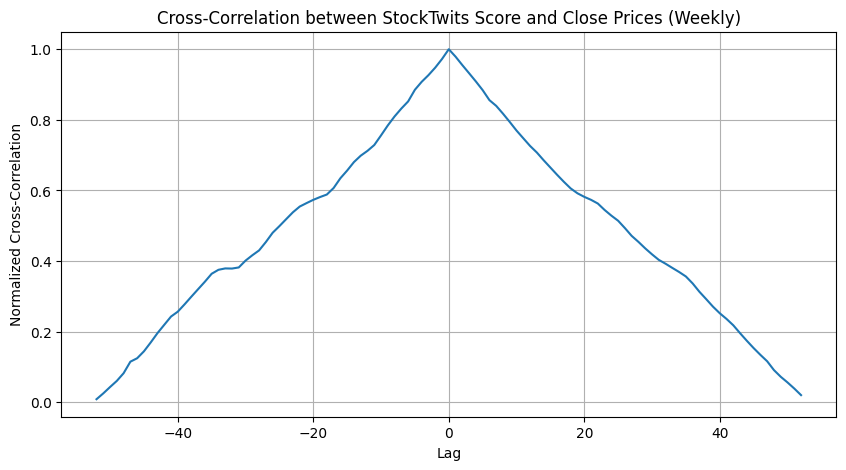

In [51]:
import numpy as np  
import matplotlib.pyplot as plt

# Extracting sentiment scores and close prices as numpy arrays
sentiment_scores = weekly_sentiment_scores['sentiment_score'].to_numpy()
close_prices = weekly_prices['Close'].to_numpy()

# Calculating cross-correlation between sentiment scores and close prices
cross_corr = np.correlate(sentiment_scores, close_prices, mode='full')

# Creating array of lag values corresponding to the cross-correlation
lags = np.arange(-len(sentiment_scores) + 1, len(sentiment_scores))

plt.figure(figsize=(10, 5))
plt.plot(lags, cross_corr / np.max(np.abs(cross_corr)))
plt.title('Cross-Correlation between StockTwits Score and Close Prices (Weekly)')
plt.xlabel('Lag')
plt.ylabel('Normalized Cross-Correlation')
plt.grid(True)
plt.show()
